In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
#import sweetviz as sv
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV


from sklearn.metrics import classification_report, roc_curve, confusion_matrix

from collections import Counter

from sklearn.impute import KNNImputer

# modelos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = df.drop(['id'], axis=1)#去掉无意义的ID属性
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [3]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
labels = [1,2,3,4,5]
df["age_mean"] = pd.cut(df["age"], 5, labels=labels)
df["age_mean"].value_counts()
grp_bmi = df.groupby("age_mean")["bmi"].mean()#将年龄阶段分为五组，分别计算平均的bmi
grp_bmi

age_mean
1    20.787661
2    28.601332
3    31.425088
4    31.580618
5    29.415118
Name: bmi, dtype: float64

In [5]:
def bmi_val(cols): #给 bmi 按年龄分配平均值   
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi
df["bmi"] = df[["bmi","age_mean"]].apply(bmi_val, axis=1)


In [6]:
df.drop("age_mean",axis=1, inplace=True)#删掉之前建的age_mean属性
df.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
df.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [8]:
df.gender.value_counts()#性别那一栏有一个Other

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
df.gender = df.gender.apply(lambda x: 0 if ((x == 'Female') or (x == 'Other')) else 1)#将other 改成 Female

In [10]:
df.gender.value_counts()

0    2995
1    2115
Name: gender, dtype: int64

In [11]:
df.dtypes


gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [12]:
ohe = OneHotEncoder(drop = 'first', sparse=False, handle_unknown = 'error')#使用onehot 将object类型类型都变成数字
df_t = pd.DataFrame(ohe.fit_transform(df.select_dtypes('object')))

df_t.columns = ohe.get_feature_names()
df_t.head(2)
df_t.shape

(5110, 9)

In [14]:
df_t

,x0_Yes,x1_Never_worked,x1_Private,x1_Self-employed,x1_children,x2_Urban,x3_formerly smoked,x3_never smoked,x3_smokes
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
df_n = df.drop(df.select_dtypes('object'), axis=1)

df = pd.concat([df_t, df_n], axis=1)
df.head(2)
#把处理过的放在后面


,x0_Yes,x1_Never_worked,x1_Private,x1_Self-employed,x1_children,x2_Urban,x3_formerly smoked,x3_never smoked,x3_smokes,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,67.0,0,1,228.69,36.6,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,61.0,0,0,202.21,31.6,1


In [15]:
df

,x0_Yes,x1_Never_worked,x1_Private,x1_Self-employed,x1_children,x2_Urban,x3_formerly smoked,x3_never smoked,x3_smokes,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1,67.0,0,1,228.69,36.6,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,61.0,0,0,202.21,31.6,1
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,80.0,0,1,105.92,32.5,1
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,49.0,0,0,171.23,34.4,1
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,80.0,1,0,83.75,29.4,0
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,81.0,0,0,125.20,40.0,0
5107,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,35.0,0,0,82.99,30.6,0
5108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,51.0,0,0,166.29,25.6,0


In [27]:
y= df['stroke']
X = df.drop('stroke', axis=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
from sklearn.linear_model import LogisticRegression  #Logistic回归（又名logit，MaxEnt）分类器。
LR = LogisticRegression(solver='liblinear')  # LR == model  == name
scores = cross_val_score(LR, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)  # model ==pipeline
print("RepeatedStratifiedKFold Validation Mean Accuracy: {:.2f} %".format(scores.mean()*100))

# from sklearn.metrics import classification_report
# print(classification_report(X, y))





RepeatedStratifiedKFold Validation Mean Accuracy: 83.61 %


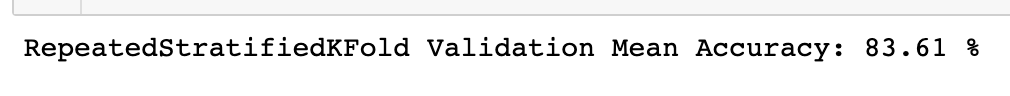

In [39]:


df.dtypes
from sklearn.model_selection import train_test_split
X = df.drop(columns=['stroke'])#分训练和测试集
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [42]:
from sklearn.svm import SVC #选出准确度最高的kernels

# model_lgr='Logistic Regression'
lr=LogisticRegression()
best_model=lr.fit(X_train,y_train)
y_pred=best_model.predict(X_test)


print("Best Accuracy :",best_model.score(X_test, y_test))


# #混淆阵
# lr_conf_matrix=confusion_matrix(y_test,y_pred)
# #准确率：
# lr_acc=accuracy_score(y_test,y_pred)
# print("confussion matrix")
# print(lr_conf_matrix)
# print("-------------------------------------------")
# print("Accuracy of Logistic Regression:",lr_acc*100,'\n')
# print("-------------------------------------------")
# print(classification_report(y_test,y_pred))



Best Accuracy : 0.9510763209393346


/Users/yys113/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


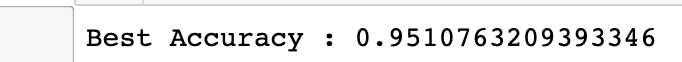
# 海英的

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

model1 = SVC(kernel = 'rbf')
model1.fit(X_train, y_train)

score = cross_val_score(model1, X_train, y_train, cv=10) #验证
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(score.mean()*100))
print("Standard Deviation: {:.2f} %".format(score.std()*100))

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))




In [ ]:
cross_val_score()

In [23]:
# #LR
# #分解版
# y= df['stroke']
# X = df.drop('stroke', axis=1)
# #用的transformer。 具体的补全形式是，使用中位数的形式。
# transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])
# pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', models[i])])    
# # scores = evaluate_model(X, y, pipeline)

# def evaluate_model(X, y, model):

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#cross_val_score  要查它 就是让nan 变出值来；就是pipeline的作用 这一步都是变数据。
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)  # model ==pipeline
scores  #通过交叉验证评估一个分数


# results.append(scores)
# print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# scores

#就用LR所以没有for循环。
LR = LogisticRegression(solver='liblinear')  # LR == model  == name
print(scores)
#其实就这些，没了。
 #mean和std又是啥。
    
print('\n')



print('>%s %.3f (%.3f)' % ('LR', np.mean(scores), np.std(scores))) 



# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


NameError: name 'pipeline' is not defined

In [16]:


df.dtypes
from sklearn.model_selection import train_test_split
X = df.drop(columns=['stroke'])#分训练和测试集
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [138]:
from sklearn.svm import SVC #选出准确度最高的kernels
kernels = ['rbf','linear','poly','sigmoid']
model = SVC()
hyperparam = [{'kernel':kernels}]
model = GridSearchCV(svc,hyperparam,cv=5,verbose=1)
best_model=model.fit(X_train,y_train)
y_pred = best_model.best_estimator_.predict( X_test)

print("Best HyperParameter: ",model.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best HyperParameter:  {'kernel': 'rbf'}
Best Accuracy : 0.9510763209393346


In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

model1 = SVC(kernel = 'rbf')
model1.fit(X_train, y_train)

score = cross_val_score(model1, X_train, y_train, cv=10) #验证
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(score.mean()*100))
print("Standard Deviation: {:.2f} %".format(score.std()*100))

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))




K-Fold Validation Mean Accuracy: 95.13 %
Standard Deviation: 0.07 %
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
